In [1]:
%matplotlib notebook
import numpy as np
import scipy.linalg as la
import mpl_toolkits.mplot3d
import matplotlib.pyplot as plt

from scipy.spatial import cKDTree

import scipy.sparse as sp
from scipy.sparse.linalg import spsolve, lsqr

from numpy.linalg import cond

In [2]:
n = 500
stencil_size = 30

# Generate Nodes

In [3]:
indices = np.arange(0, n, dtype=float) + 0.5

phi = np.arccos(1 - 2*indices/n)
theta = np.pi * (1 + 5**0.5) * indices

xs, ys, zs = np.cos(theta) * np.sin(phi), np.sin(theta) * np.sin(phi), np.cos(phi)
nodes = [(x,y,z) for x,y,z in zip(xs,ys,zs)]

<IPython.core.display.Javascript object>


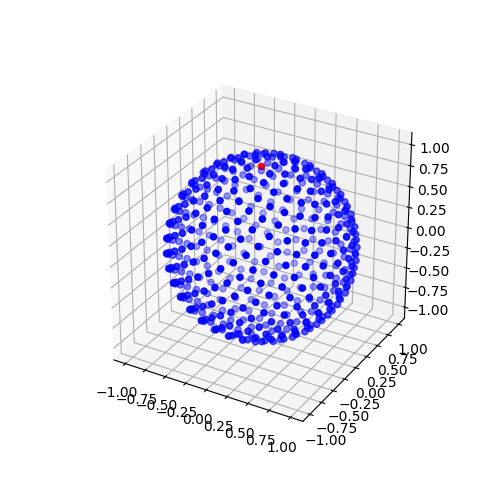

In [4]:
# Plot nodes
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs[1:], ys[1:], zs[1:], c='b')
ax.scatter(xs[0], ys[0], zs[0], c='r')

In [5]:
tree = cKDTree(np.array(nodes))
stencils = [tree.query(node, stencil_size)[1] for node in nodes]

# Functions

In [6]:
def dist(node1, node2):
    return np.sqrt( (node1[0]-node2[0])**2 + (node1[1]-node2[1])**2 + (node1[2]-node2[2])**2 )

def rbf(node1, node2):
    r = dist(node1, node2)
    return r**5
def d_phi_dr_div_r(r):
    return 5*r**3

def P_grad_rbf_x(node1, node2):
    r = dist(node1, node2)
    return d_phi_dr_div_r(r) * (1-r**2) * (node1[0] - node2[0])
def P_grad_rbf_y(node1, node2):
    r = dist(node1, node2)
    return d_phi_dr_div_r(r) * (1-r**2) * (node1[1] - node2[1])
def P_grad_rbf_z(node1, node2):
    r = dist(node1, node2)
    return d_phi_dr_div_r(r) * (1-r**2) * (node1[2] - node2[2])

# Calculate Weights

In [7]:
weights = np.zeros((n, stencil_size))
row_index = [r for r in range(n) for c in range(stencil_size)]
col_index = np.zeros((n, stencil_size))

for i, stencil in enumerate(stencils):
    col_index[i] = stencil
    nn = [nodes[i] for i in stencil]
    
    A = np.array([[rbf(node1, node2) for node1 in nn] for node2 in nn])
    P = np.array([[1, x, y, z] for x,y,z in nn])
    AP = np.block([[A,P],[P.T, np.zeros((4,4))]])
    
    rhsA = np.array([[P_grad_rbf_x(node1, node2) for node2 in nn] for node1 in nn])
    rhs = np.block([[rhsA],
                    [np.zeros(stencil_size)],
                    [1-node[0]**2 for node in nn],
                    [-node[0]*node[1] for node in nn],
                    [-node[0]*node[2] for node in nn] ])
    weights_grad = la.solve(AP, rhs)[:stencil_size,:].T
    
    weights[i] = (weights_grad@weights_grad)[0]
    
    rhsA = np.array([[P_grad_rbf_y(node1, node2) for node2 in nn] for node1 in nn])
    rhs = np.block([[rhsA],
                    [np.zeros(stencil_size)],
                    [-node[0]*node[1] for node in nn],
                    [1-node[1]**2 for node in nn],
                    [-node[1]*node[2] for node in nn] ])
    weights_grad = la.solve(AP, rhs)[:stencil_size,:].T
    
    weights[i] += (weights_grad@weights_grad)[0]
    
    rhsA = np.array([[P_grad_rbf_z(node1, node2) for node2 in nn] for node1 in nn])
    rhs = np.block([[rhsA],
                    [np.zeros(stencil_size)],
                    [-node[0]*node[2] for node in nn],
                    [-node[1]*node[2] for node in nn],
                    [1-node[2]**2 for node in nn] ])
    weights_grad = la.solve(AP, rhs)[:stencil_size,:].T
    
    weights[i] += (weights_grad@weights_grad)[0]
    
C = sp.csc_matrix((weights.ravel(), (row_index, col_index.ravel())),shape=(n,n))

In [8]:
cond(C.todense())

3.625613843211178e+16

# Extra Condition

In [9]:
Clam = sp.vstack( [sp.hstack([C, np.ones((n,1))], format='csr'), 
                    np.block([np.ones((1,n)), np.zeros((1,1))]) ], format='csr')

In [10]:
print(cond(Clam.todense()))

253978.6737471378


# Solve

In [11]:
# l=1
def foo1(node):
    return node[0]*2
def exact1(node):
    return node[0]


# l=3
def foo2(node):
    return (node[0]**2 - node[1]**2) * 6
def exact2(node):
    return (node[0]**2 - node[1]**2)

def foo3(node):
    return (node[0]**2 - node[1]**2) * node[2] * 12
def exact3(node):
    return (node[0]**2 - node[1]**2) * node[2]


foo, exact = foo1, exact1

In [12]:
rhs = [-foo(node) for node in nodes] + [0]
#u = lsqr(Clam, rhs)[0]
u = spsolve(Clam, rhs)
u = u[:-1]

In [16]:
u_true = np.array([exact(node) for node in nodes])
print(np.max(np.abs(2*u - u_true)))
print(np.min(u))
print(np.max(u))

0.1299545411552654
-0.5181563933485329
0.5267674562897015


# Plot Solution

<IPython.core.display.Javascript object>


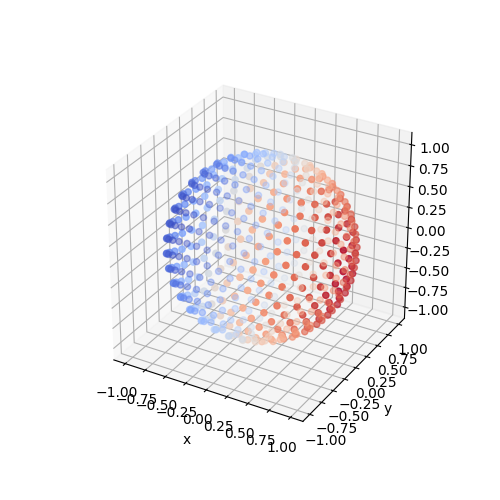

Text(0.5,0,'y')

In [14]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs, c=u, cmap='coolwarm')
plt.xlabel('x')
plt.ylabel('y')

# Plot Expected Solution

<IPython.core.display.Javascript object>


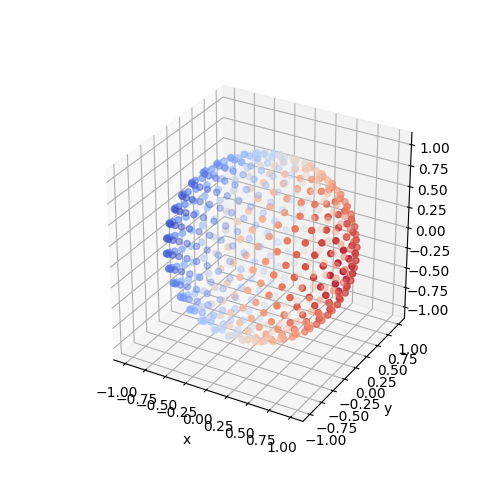

Text(0.5,0,'y')

In [15]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs, c=[exact(node) for node in nodes], cmap='coolwarm')
plt.xlabel('x')
plt.ylabel('y')